In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 5000


In [40]:
lsbg = lsbg_cat[3939]

In [41]:
lsbg

<Row index=3939>
viz-id         ra                 dec             mag_auto_i          sersic_n           sersic_ell          sersic_PA      sersic_rhalf_circ               sersic_sed [4]                              mags [4]                             prefix             image_flag [4] psf_flag [4]
int64       float64             float64            float64            float64             float64             float64            float64                       float64                                  float64                             bytes65                  bool          bool    
------ ------------------ ------------------- ------------------ ------------------ -------------------- ------------------ ------------------ ---------------------------------------- ---------------------------------------- ------------------------------ -------------- ------------
  3939 129.60471566923957 0.06613401986448465 16.175076413369258 0.9901436270723474 0.012167984260451958 -47.93957247414054 12.553487338561522 0.5333770303270018 .. 1.0226103853218256 16.857490640782462 .. 16.150800915928414 ./Cutout/mock_sample/mock_3939   True .. True True .. True

In [42]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = True


In [45]:
def command(low, num=500):
    string = f'python deploy_mock.py --name spgl_{low/1000:.1f}k --ncpu=12 '
    string += f'--method=spergel --low={low} --high={low+num} '
    string += f'--monotonic=True --bkg=True --min_grad=-0.05 '
    print(string)
    return
    
for i in range(4, 10):
    command(i * 500, 500)

python deploy_mock.py --name spgl_2.0k --ncpu=12 --method=spergel --low=2000 --high=2500 --monotonic=True --bkg=True --min_grad=-0.05 
python deploy_mock.py --name spgl_2.5k --ncpu=12 --method=spergel --low=2500 --high=3000 --monotonic=True --bkg=True --min_grad=-0.05 
python deploy_mock.py --name spgl_3.0k --ncpu=12 --method=spergel --low=3000 --high=3500 --monotonic=True --bkg=True --min_grad=-0.05 
python deploy_mock.py --name spgl_3.5k --ncpu=12 --method=spergel --low=3500 --high=4000 --monotonic=True --bkg=True --min_grad=-0.05 
python deploy_mock.py --name spgl_4.0k --ncpu=12 --method=spergel --low=4000 --high=4500 --monotonic=True --bkg=True --min_grad=-0.05 
python deploy_mock.py --name spgl_4.5k --ncpu=12 --method=spergel --low=4500 --high=5000 --monotonic=True --bkg=True --min_grad=-0.05 


In [43]:
# fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2,
#                        monotonic=True, bkg=True,
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
#                        model_dir='./Model/mock_sample/',
#                        figure_dir='./Figure/mock_sample',
#                        log_dir='./log/mock_sample',
#                        prefix='mock', 
#                        index=lsbg['viz-id'], 
#                        show_figure=True)
# fitter.load_data(data, lsbg_coord)

fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2, bkg=True,
#                        min_grad=-0.2, bkg=True, thresh=0.1, # starlet_thresh=0.5,
                       min_grad=-0.05, thresh=0.1, bkg=True,
#                        monotonic=True, 
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    19 stars from Gaia are masked!
    Detected 275 objects
    18 stars from Gaia are masked!
    Detected 190 objects
    Detected 108 objects
  - Added Spergel profile with bbox = (4, 579, 579)
    Added constant sky background
    Total number of sources: 38
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 201 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 264 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 294 iterations! Try higher accuracy!
  - After 294 iterations, logL = -528061.51
    Elapsed time for fitting: 340.89 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
    1 stars from Gaia are masked!
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/moc

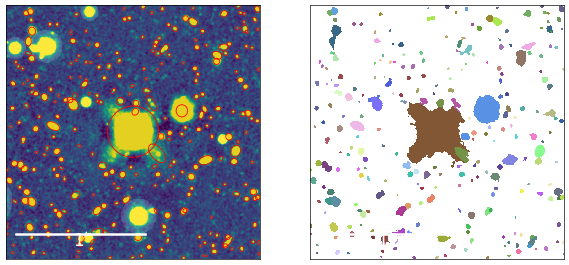

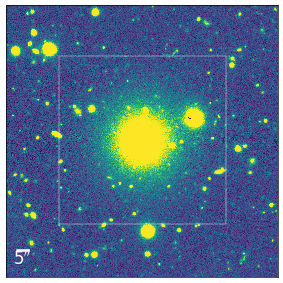

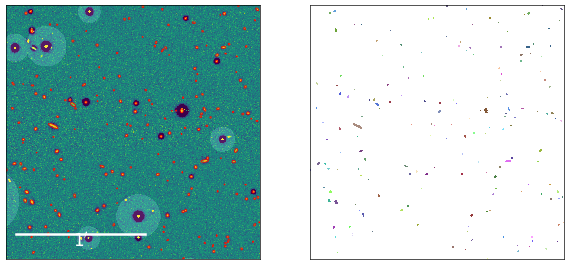

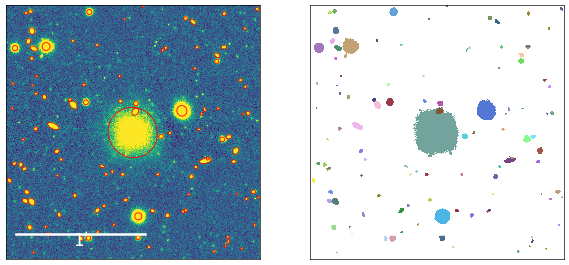

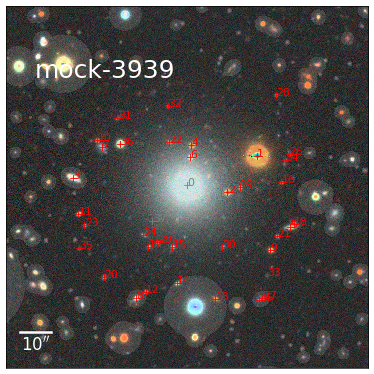

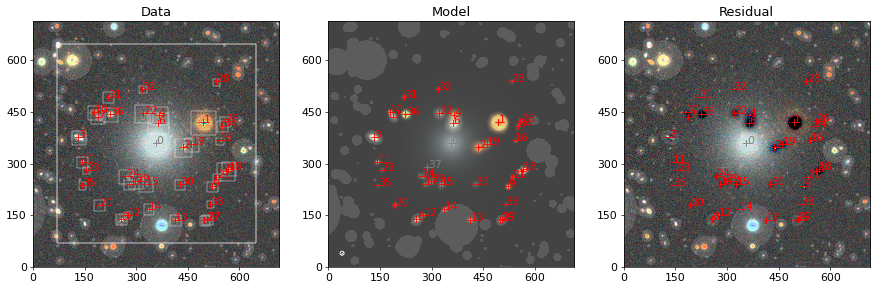

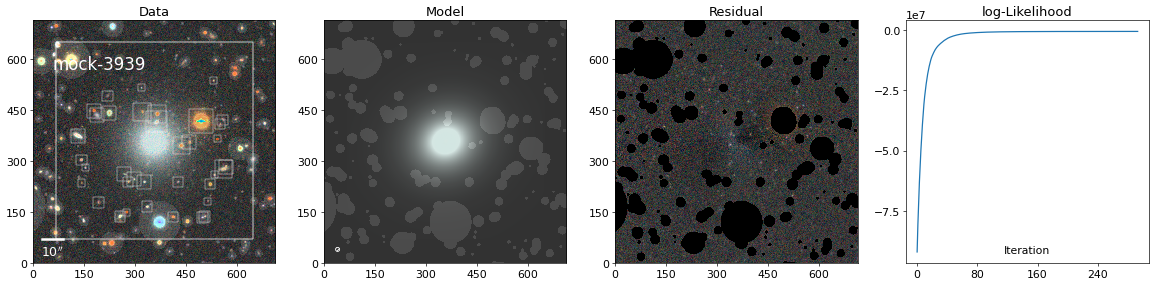

In [44]:
fitter.fit()

In [46]:
david = fitter.blend.sources[0]
print("Re", david.parameters[3] * 0.168)
from kuaizi.measure import nu_to_n
print('n', nu_to_n(david.parameters[2]))

from kuaizi.measure import cal_cnu
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]
             ** 2) / cal_cnu(david.parameters[2])**2
print('mag', -2.5 * np.log10(true_flux * sed) + 27)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

Re [[13.45282985]]
n [[1.03683134]]
mag [[16.79947248 16.27085268 16.08253398 16.0402282 ]]
Sky: [        inf         inf 28.56951753 27.73722092]


{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9901436270723474,
    'half_light_radius': 12.553487338561522},
   'shear_params': {'q': 0.987832015739548,
    'beta': coord.Angle(-0.8367033816721966, coord.radians)},
   'sed': array([0.53337703, 0.85610552, 1.        , 1.02261039])}],
 'imag': 16.175076413369258,
 'flux_fraction': [1.0],
 'ra': 129.60471566923957,
 'dec': 0.06613401986448465,
 'gmag': 16.857490640782462,
 'rmag': 16.343758170639607,
 'zmag': 16.150800915928414}

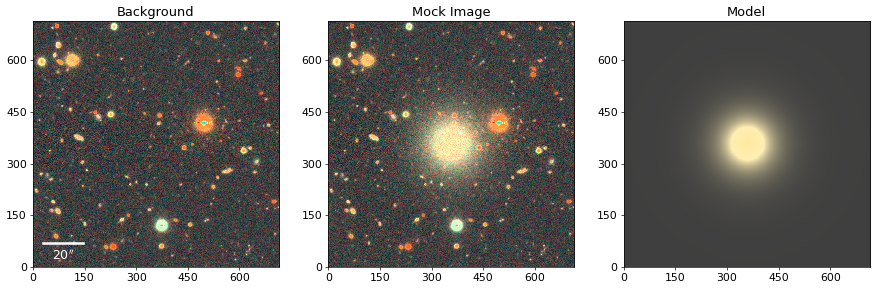

In [47]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)
gal.model.info

#### Step-by-step

In [484]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!


In [485]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 270 objects


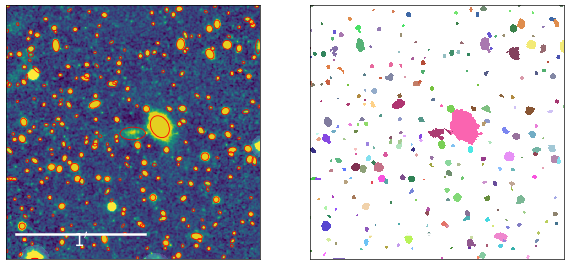

In [486]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
# fitter._first_detection(1e-3, conv_radius=2, lvl=5, b=40)
fitter._first_detection(1e-3, conv_radius=2, lvl=4, b=40)

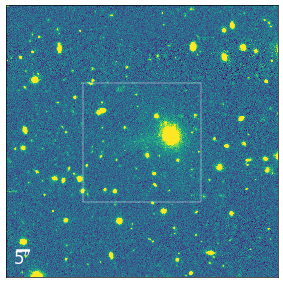

In [487]:
fitter._estimate_box(fitter.cen_obj)

In [443]:
fitter._mask_stars_outside_box()

    16 stars from Gaia are masked!


    Detected 268 objects


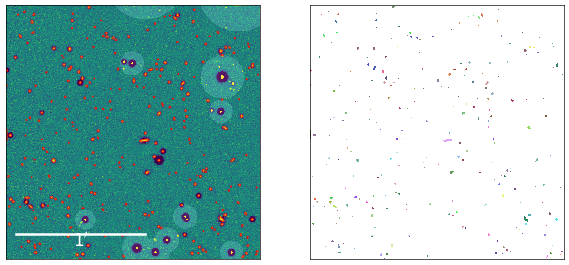

In [444]:
fitter._cpct_obj_detection()

In [445]:
from kuaizi.display import draw_circles

    Detected 140 objects


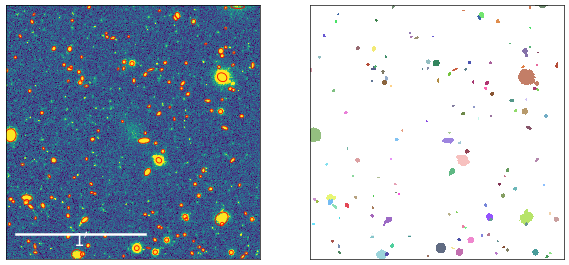

In [446]:
fitter._big_obj_detection()

In [447]:
fitter._merge_catalogs()

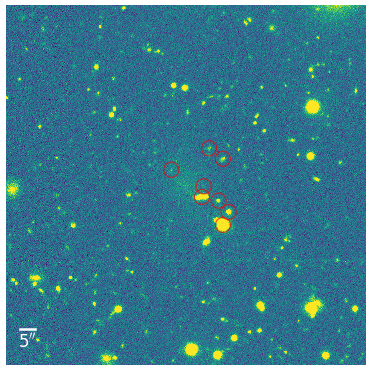

In [448]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [449]:
fitter._construct_obs_frames()

In [450]:
fitter._add_central_source(min_grad=-0.2, thresh=0.05)
# fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)
fitter._add_other_sources(min_grad=0.1, thresh=0.1)

  - Added Spergel profile with bbox = (4, 350, 350)
    Added constant sky background
    Total number of sources: 19


In [451]:
fitter.blend.sources[0].parameters[1]

Parameter([357.09082892, 356.13571   ])

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

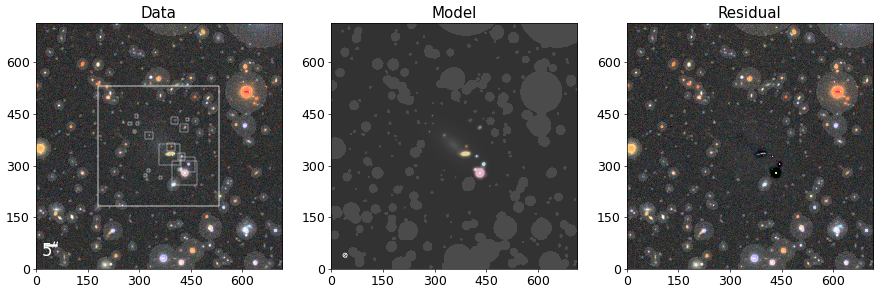

In [452]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 105 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 147 iterations! Try higher accuracy!
  - After 147 iterations, logL = 2314636.98


PicklingError: Can't pickle <class 'scarlet.morphology.SpergelMorphology'>: it's not the same object as scarlet.morphology.SpergelMorphology

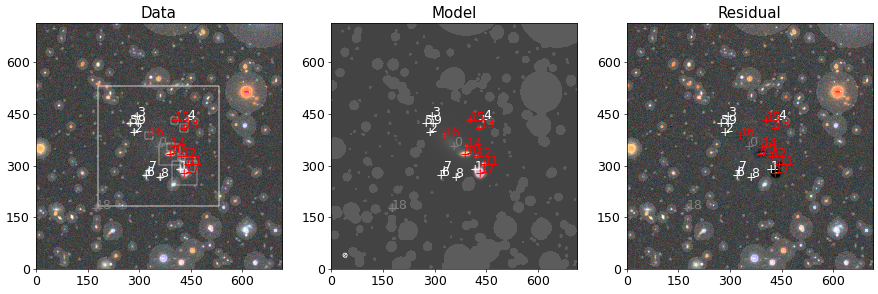

In [453]:
fitter._optimize()

In [455]:
david = fitter.blend.sources[0]
print("Re", david.parameters[3] * 0.168)
from kuaizi.measure import nu_to_n
print('n', nu_to_n(david.parameters[2]))

from kuaizi.measure import cal_cnu
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]
             ** 2) / cal_cnu(david.parameters[2])**2
print('mag', -2.5 * np.log10(true_flux * sed) + 27)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

Re [[10.40947018]]
n [[0.8616252]]
mag [[19.95910768 19.48094944 19.36437512 19.50429145]]
Sky: [30.20167584 30.17617106 30.84875286         inf]


In [456]:
david.parameters[1]

Parameter([353.0264969 , 360.88976831])

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-73-trained-model-spergel.df


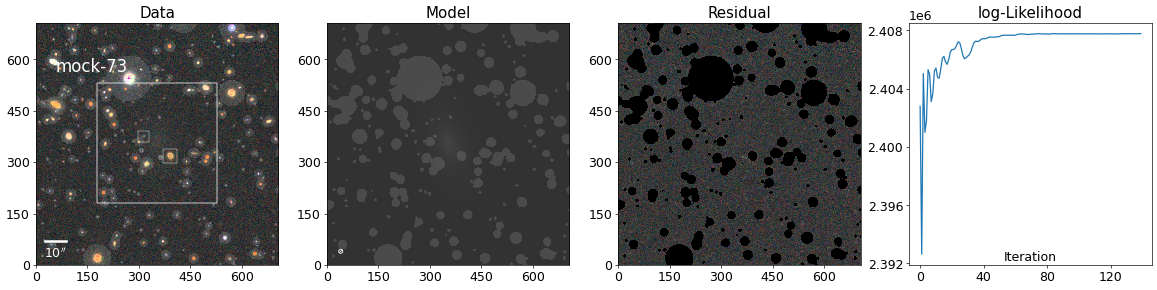

In [311]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

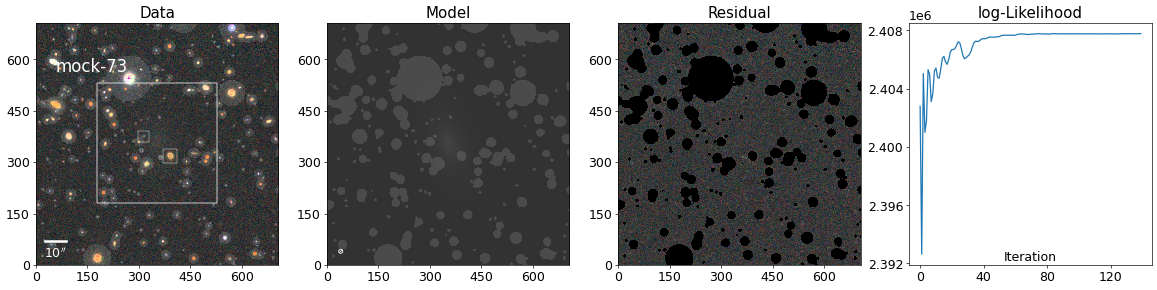

In [312]:
fitter._display_results()

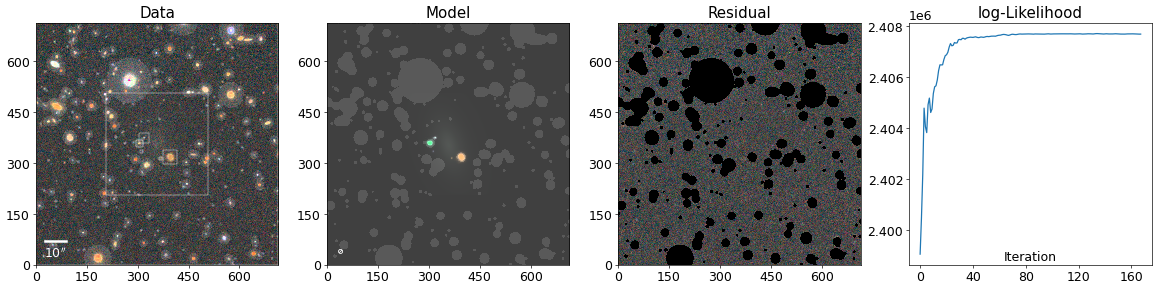

In [279]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [280]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

[[9.90949579]]
mag: [[20.66161922 20.05353985 19.76333128 19.91861944]]
Sky: [71.93485585 71.91178867 72.10168015         nan]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

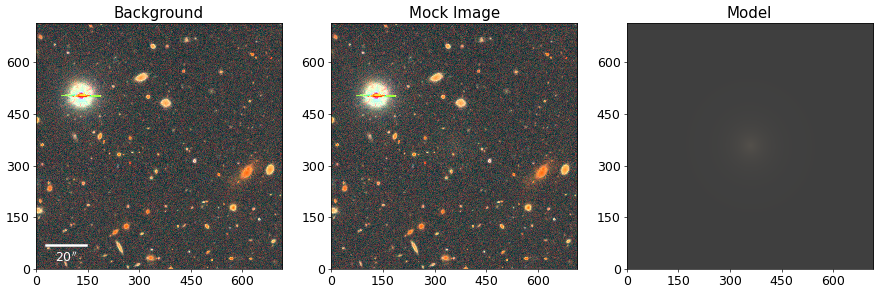

In [241]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)
gal.model.info

In [100]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

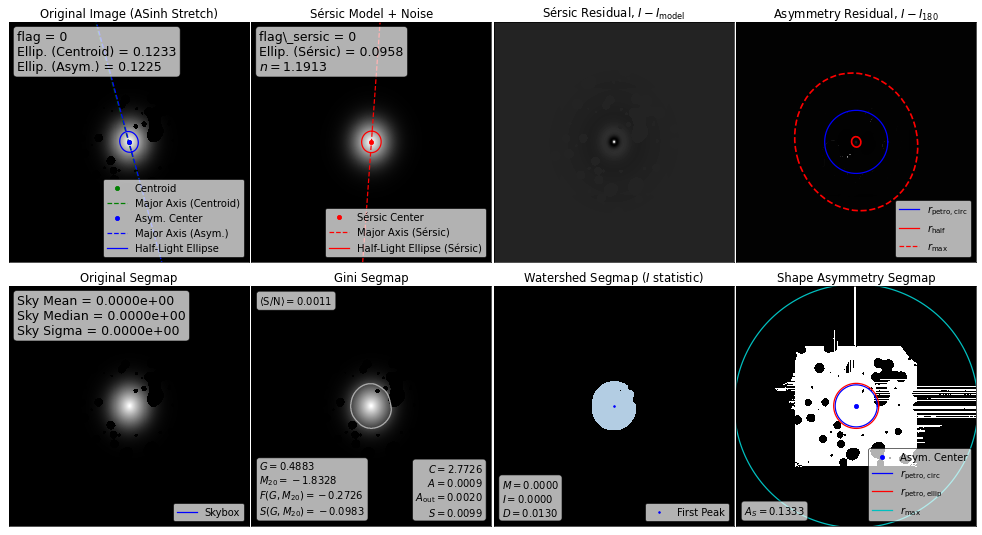

In [101]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [102]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([29.4934964 , 28.74595229, 28.74534842, 28.11704383])

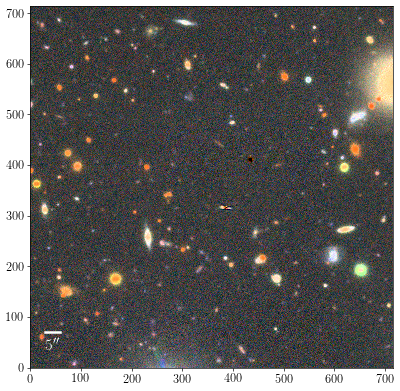

In [142]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)

In [225]:
import dill
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

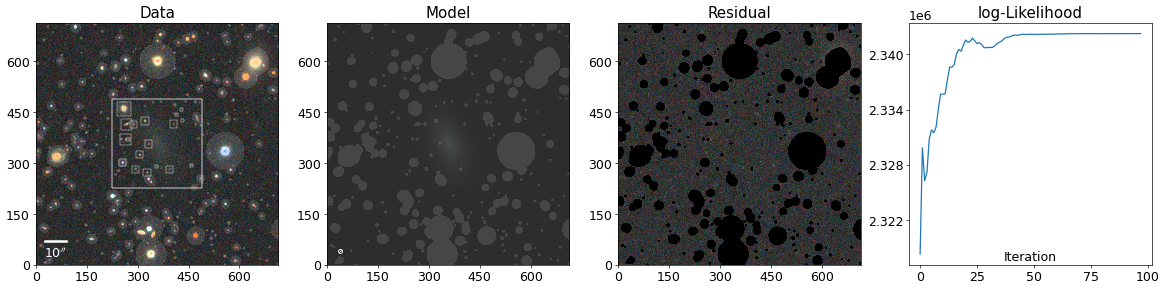

In [505]:
ind = 45
method = 'spergel'
# method = 'vanilla'
with open(f'./Model/mock_sample/spergel/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

In [506]:
print(blend.sources[0].bbox)

<Box shape=(4, 264, 264), origin=(0, 226, 225)>


In [507]:
from kuaizi.measure import cal_cnu
david = blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
-2.5 * np.log10(true_flux * sed) + 27.0

[[9.45965435]]


Parameter([[20.01042132, 19.38141829, 19.1376621 , 19.25541846]])

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

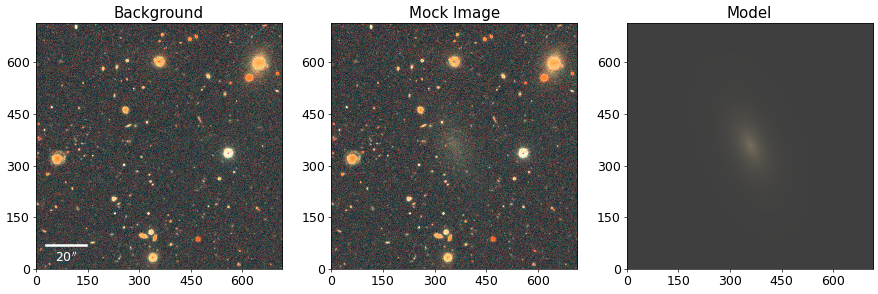

In [508]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [509]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9709945816361072,
    'half_light_radius': 11.396585941710288},
   'shear_params': {'q': 0.5446791193492302,
    'beta': coord.Angle(-1.1878169491512438, coord.radians)},
   'sed': array([0.45517963, 0.7966135 , 1.        , 1.04417496])}],
 'imag': 18.847483812563148,
 'flux_fraction': [1.0],
 'ra': 218.03444882694023,
 'dec': -0.4767721358517475,
 'gmag': 19.702026759357402,
 'rmag': 19.094364660509527,
 'zmag': 18.800550624001026}

In [17]:
src = blend.sources[0]

In [18]:
sed, morph = src.get_models_of_children()

In [23]:
from kuaizi.measure import cal_cnu

In [24]:
true_flux = (2 * np.pi * src.parameters[3]
             ** 2) / cal_cnu(src.parameters[2])**2

In [25]:
true_flux

Parameter([[2281.71784862]])

In [ ]:
measure_dict['flux'] = np.array(true_flux * sed).ravel()

In [15]:
measurement['mag'] + 2.5 * np.log10(2 * np.pi * 5.29124731838925**2)

array([25.68790056, 25.17335591, 24.890307  , 24.7395501 ])